#### Denoising AutoEncoder for MNIST dataset

In [ ]:
# Necessary Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


100%|██████████| 9912422/9912422 [00:00<00:00, 86997767.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 11971113.14it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29058123.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12691891.25it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Torch transforms of Images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load train and test data
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
# Define Class of Denoising AutOEncoder for grayscale mnist with 28*28 pixels
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x


In [ ]:
# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Instantiate AE
model = DenoisingAutoencoder()

In [ ]:
# Define training loop

num_epochs = 10

for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        noisy_data = torch.randn(data.size()) * 0.1 + data
        optimizer.zero_grad()
        output = model(noisy_data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))


Epoch [1/10], Step [1/469], Loss: 0.9245
Epoch [1/10], Step [101/469], Loss: 0.2599
Epoch [1/10], Step [201/469], Loss: 0.1850
Epoch [1/10], Step [301/469], Loss: 0.1537
Epoch [1/10], Step [401/469], Loss: 0.1422
Epoch [2/10], Step [1/469], Loss: 0.1194
Epoch [2/10], Step [101/469], Loss: 0.1161
Epoch [2/10], Step [201/469], Loss: 0.1053
Epoch [2/10], Step [301/469], Loss: 0.1032
Epoch [2/10], Step [401/469], Loss: 0.1013
Epoch [3/10], Step [1/469], Loss: 0.0943
Epoch [3/10], Step [101/469], Loss: 0.0894
Epoch [3/10], Step [201/469], Loss: 0.0920
Epoch [3/10], Step [301/469], Loss: 0.0848
Epoch [3/10], Step [401/469], Loss: 0.0831
Epoch [4/10], Step [1/469], Loss: 0.0823
Epoch [4/10], Step [101/469], Loss: 0.0787
Epoch [4/10], Step [201/469], Loss: 0.0777
Epoch [4/10], Step [301/469], Loss: 0.0730
Epoch [4/10], Step [401/469], Loss: 0.0678
Epoch [5/10], Step [1/469], Loss: 0.0764
Epoch [5/10], Step [101/469], Loss: 0.0673
Epoch [5/10], Step [201/469], Loss: 0.0706
Epoch [5/10], Step [3

In [ ]:
# Define Evaluation 
model.eval()
test_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        noisy_data = torch.randn(data.size()) * 0.1 + data
        output = model(noisy_data)
        test_loss += criterion(output, data).item()

    test_loss /= len(test_loader.dataset)
    print('Test Loss: {:.4f}'.format(test_loss))


Test Loss: 0.0004


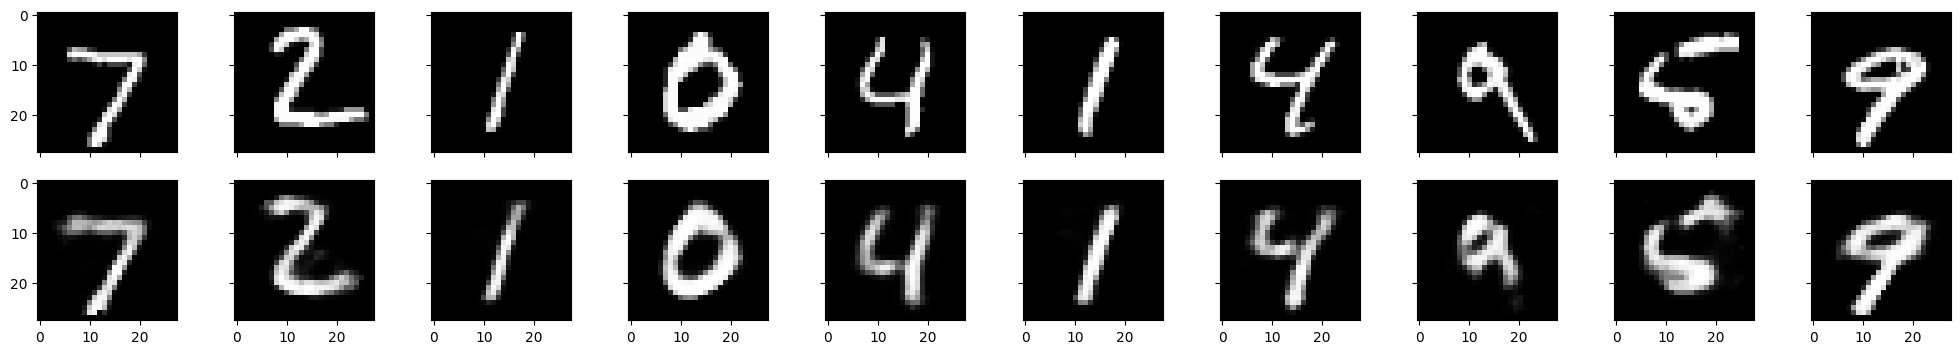

In [ ]:
# Test AutoEncoder

# Select a few random test images
data_iter = iter(test_loader)
images, _ = next(data_iter)

# Add noise to the images
noisy_images = torch.randn(images.size()) * 0.1 + images

# Generate denoised reconstructions
reconstructions = model(noisy_images)

# Plot the original images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

for i in range(10):
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')
    axes[1, i].imshow(reconstructions[i].squeeze().detach().numpy(), cmap='gray')

plt.show()


In [ ]:
# !!!!! ALternative to previous loop
# Define Train and Validation Loop in one loop 
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    for data, _ in train_loader:
        optimizer.zero_grad()
        noisy_data = torch.randn(data.size()) * 0.1 + data
        output = model(noisy_data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            noisy_data = torch.randn(data.size()) * 0.1 + data
            output = model(noisy_data)
            loss = criterion(output, data)
            test_loss += loss.item()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(
        epoch+1, num_epochs, train_loss, test_loss))


Epoch [1/10], Train Loss: 0.0004, Test Loss: 0.0004
Epoch [2/10], Train Loss: 0.0004, Test Loss: 0.0004
Epoch [3/10], Train Loss: 0.0004, Test Loss: 0.0004
Epoch [4/10], Train Loss: 0.0004, Test Loss: 0.0004
Epoch [5/10], Train Loss: 0.0004, Test Loss: 0.0003
Epoch [6/10], Train Loss: 0.0004, Test Loss: 0.0003
Epoch [7/10], Train Loss: 0.0003, Test Loss: 0.0003
Epoch [8/10], Train Loss: 0.0003, Test Loss: 0.0003
Epoch [9/10], Train Loss: 0.0003, Test Loss: 0.0003
Epoch [10/10], Train Loss: 0.0003, Test Loss: 0.0003


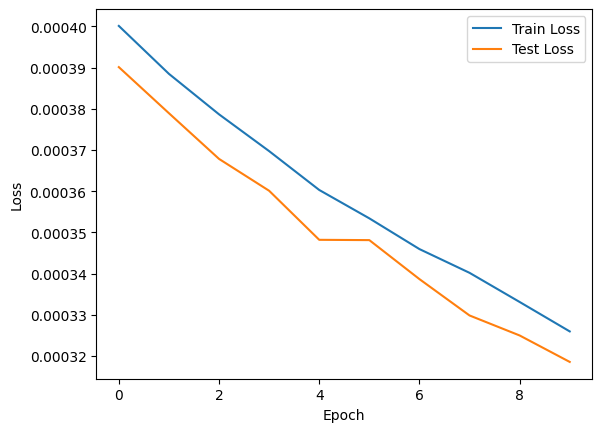

In [ ]:
# Visualize train and validation Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()